# Поиск подходящих элементов программы для спортсменов

**Описание проекта**

Сервис  “Мой Чемпион” помогает спортивным школам фигурного катания,
<br>тренерам мониторить результаты своих подопечных и планировать дальнейшее развитие спортсменов.

**Цель**

Создать модель, помогающую находить элементы, которые могут быть успешно исполнены спортсменом на соревновании. 
<br>Сервис будет прогнозировать прогресс и возможное выполнение тех или иных элементов программы
<br>по истории предыдущих выступлений и выполнения элементов на соревнованиях.

**Описание данных**

- `units`
  - `id`: идентификатор юнита
  - `color`: категория
  - `school_id`: идентификатор школы
- `tournaments`
  - `id`: идентификатор турнира
  - `date_start`: дата начала
  - `date_end`: дата завершения
  - `origin_id`: место проведения
- `total_scores`
  - `id`: идентификатор выступления, джойнится с `tournament_scores.total_score_id`
  - `unit_id`: идентификатор юнита, ключ к `units.id`
  - `tournament_id`: идентификатор турнира, `tournaments.id`
  - `components_score`: артистизм (мастерство, композиция, хореография)
  - `base_score`: базовая оценка за элементы в выступлении (идеал)
  - `elements_score`: реальная оценка всех выполненных элементов, base_score+goe
  - `decreasings_score`: снижения оценок за ошибки
  - `total_score`: `components_score` + `elements_score` + `decreasings_score` за выступление
  - `starting_place`:
  - `place`: занятое место в категории `category_name` + `segment_name`
  - `segment_name`: название сегмента
  - `info`: комментарии и пояснения к оценке
  - `overall_place`: итоговое место в турнире
  - `overall_total_score`: итоговая оценка за весь турнир
  - `overall_place_str`: комментарии, пояснения
- `tournament_scores`
  - `id`: идентификатор оценки за конкретный элемент/комбинацию
  - `total_score_id`: идентикатор выступления, ключ `total_scores.id`
  - `title`: запись элемента или комбинации элементов с отметками об ошибках
  - `decrease`: за что снижена оценка
  - `base_score`: базовая оценка (идеал, цена данного элемента/комбинации, сложность)
  - `goe`: Grade of Execute, качество исполнения, судейские надбавки/убавки
  - `avg_score`: оценка за элемент/комбинацию (усредненная по судьям)

**План выполнения**

- Объединение данных – спортсмены, юниты, соревнования, сегменты, школы, тренеры;
- Проведение анализа данных;
- Выделение всех элементов фигурного катания, представленых в виде объединенной строки с набором элементов, например `2F!<<+2Lo<<CCoSp2V*`;
  - Актуальный список элементов можно посмотреть [здесь](https://eislauf-union.de/files/users/997/Elemente-Liste2023_24.pdf) - категория `Single skating`, а также специальные отметки `Special codes` в конце документа;
- Выделение элементов успешно выполненных и с погрешностями (имеют специальные пометки);
- Агрегация датасета и подготовка обучающих признаков;
- Создание модели для предсказания вероятности успешного выполнения элементов;
- Улучшение решения: анализ признаков, выявление ошибок и слабых сторон модели;
- Создание функции (класса) для применения в сервисе:
  - возможность регулировки длины истории спортсмена для построения прогноза,
  - добавление запланированной программы элементов в качестве признака;
- Проведение тестирования решения;
- Создание документации;
- Заключение (отчёт по проделанной работе).

## Setting up the work environment

In [30]:
# !pip install pandas
# !pip install python-dotenv
# !pip install seaborn
# !pip install psycopg2-binary

!pip freeze > requirements.txt

In [36]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from dotenv import load_dotenv
os.environ['VIRTUAL_ENV']

'/home/denis/Documents/main_venv/goprotect/.gp_env'

Declaring Global Variables

In [37]:
UNITS_PATH = 'data/units.csv'
SCORES_PATH = 'data/total_scores.csv'
TOURNAMENTS_PATH = 'data/tournaments.csv'
TOURNAMENT_SCORES_PATH = 'data/tournament_scores.csv'

ASSETS_DIR = 'assets'
RANDOM_STATE = 42

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
TRACKING_SERVER_PORT = 5000
TRACKING_SERVER_HOST = '127.0.0.1'
EXPERIMENT_NAME = 'goprotect_athletes'

load_dotenv()
sns.set_style('white')
sns.set_theme(style='whitegrid')
pd.options.display.max_rows = 20
pd.options.display.max_columns = 30

connection = {'sslmode': 'require',
              'target_session_attrs': 'read-write'}
postgres_credentials = {'host': os.getenv('DB_HOST'),
                        'port': os.getenv('DB_PORT'),
                        'dbname': os.getenv('DB_NAME'),
                        'user': os.getenv('DB_USERNAME'),
                        'password': os.getenv('DB_PASSWORD')}

Importing a Research Class

In [4]:
%load_ext autoreload
%autoreload 2

from research_class import DatasetExplorer

## EDA

### units

In [5]:
units_explorer = DatasetExplorer(UNITS_PATH)

Общая информация по набору данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4596 entries, 0 to 4595
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         4596 non-null   int64  
 1   color      4595 non-null   object 
 2   school_id  4007 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 107.8+ KB

Первые пять строк набора данных:


,id,color,school_id
0,9474,green,244.0
1,733,green,203.0
2,734,green,235.0
3,735,green,168.0
4,736,green,168.0



Количество полных дубликатов строк:


0


Количество пропущенных значений:


id             0
color          1
school_id    589
dtype: int64

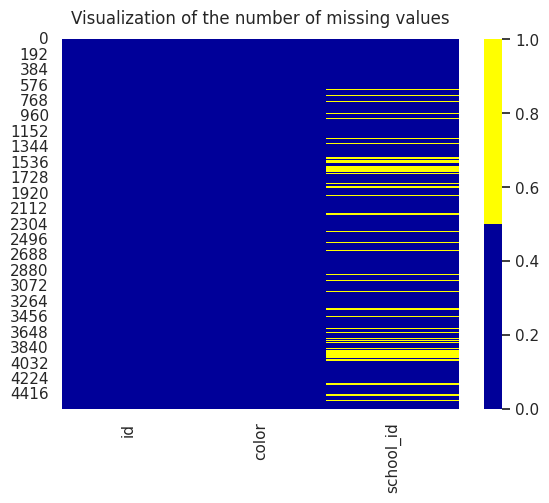


Процент пропущенных значений в признаках:
color: 0.02%
school_id: 12.82%
Количество уникальных значений в столбце 'id': 4596
Соотношение уникальных значений и общего количества записей в столбце 'id': 1.0000
Количество уникальных значений в столбце 'school_id': 239
Соотношение уникальных значений и общего количества записей в столбце 'school_id': 0.0520


In [13]:
units = units_explorer.explore_dataset()

Выводы и наблюдения:
- полных дубликатов строк в данных не обнаружено;
- количество пропущенных идентификаторов школ примерно 13% от всех записей;
- количество пропущенных категорий в общем числе записей - 1;
- количество уникальных идентификаторов школ - 239

### scores

In [7]:
scores_explorer = DatasetExplorer(SCORES_PATH)

Общая информация по набору данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21301 entries, 0 to 21300
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   21301 non-null  int64  
 1   unit_id              21301 non-null  int64  
 2   tournament_id        21301 non-null  int64  
 3   base_score           21301 non-null  float64
 4   components_score     21301 non-null  float64
 5   total_score          21301 non-null  float64
 6   elements_score       21301 non-null  float64
 7   decreasings_score    21301 non-null  float64
 8   starting_place       21301 non-null  int64  
 9   place                21301 non-null  int64  
 10  segment_name         21284 non-null  object 
 11  info                 20720 non-null  object 
 12  overall_place        21301 non-null  int64  
 13  overall_total_score  21284 non-null  float64
 14  overall_place_str    10814 non-null  object 
dtypes

,id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str
0,442027,304,4785,47.2,43.47,102.70,59.23,0.0,17,1,Короткая программа,x Надбавка за прыжки во второй половине програ...,2,293.74,2
1,442028,604,4785,45.4,46.71,101.19,54.48,0.0,18,2,Короткая программа,q Прыжок приземлён в четверть x Надбавка за пр...,1,294.75,1
2,442029,409,4785,44.0,46.82,99.20,52.38,0.0,6,3,Короткая программа,q Прыжок приземлён в четверть x Надбавка за пр...,4,285.57,4
3,442030,524,4785,46.2,44.86,91.84,47.98,-1.0,3,4,Короткая программа,q Прыжок приземлён в четверть x Надбавка за пр...,3,292.42,3
4,442031,412,4785,44.2,42.59,89.73,48.14,-1.0,15,5,Короткая программа,q Прыжок приземлён в четверть x Надбавка за пр...,6,265.34,6



Количество полных дубликатов строк:


0


Количество пропущенных значений:


id                         0
unit_id                    0
tournament_id              0
base_score                 0
components_score           0
total_score                0
elements_score             0
decreasings_score          0
starting_place             0
place                      0
segment_name              17
info                     581
overall_place              0
overall_total_score       17
overall_place_str      10487
dtype: int64

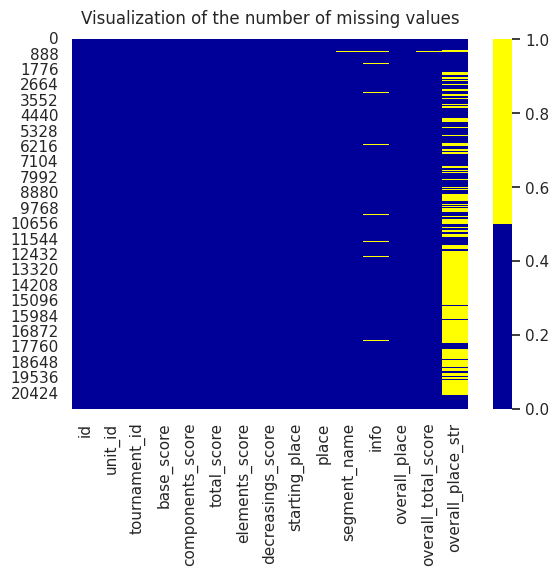


Процент пропущенных значений в признаках:
segment_name: 0.08%
info: 2.73%
overall_total_score: 0.08%
overall_place_str: 49.23%
Количество уникальных значений в столбце 'id': 21301
Соотношение уникальных значений и общего количества записей в столбце 'id': 1.0000
Количество уникальных значений в столбце 'unit_id': 3393
Соотношение уникальных значений и общего количества записей в столбце 'unit_id': 0.1593
Количество уникальных значений в столбце 'tournament_id': 142
Соотношение уникальных значений и общего количества записей в столбце 'tournament_id': 0.0067


In [14]:
scores = scores_explorer.explore_dataset()

Выводы и наблюденоия:
- полных дубликатов строк в данных не обнаружено;
- в нескольких признаках имеются пропущенные данные -
  <br>больше всего пропусков в признаке с комментариями `overall_place_str` - 49.23%;
- почти все признаки представлены числовыми значениями, один признак - категориальный,
  <br>два признака текстовые - их нужно рассмотреть подробнее на предмет извлечения информации.

### tournaments

In [9]:
tournaments_explorer = DatasetExplorer(TOURNAMENTS_PATH)

In [15]:
tournaments = tournaments_explorer.explore_dataset()

Общая информация по набору данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          142 non-null    int64  
 1   date_start  142 non-null    object 
 2   date_end    142 non-null    object 
 3   origin_id   142 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ KB

Первые пять строк набора данных:


,id,date_start,date_end,origin_id
0,1,2090-11-29,2090-12-01,2.0
1,2,2091-03-06,2091-03-10,1.0
2,3,2090-10-05,2090-10-08,2.0
3,4,2090-10-18,2090-10-21,2.0
4,5,2090-10-21,2090-10-24,2.0



Количество полных дубликатов строк:


0


Количество пропущенных значений:


id            0
date_start    0
date_end      0
origin_id     0
dtype: int64


Процент пропущенных значений в признаках:
Количество уникальных значений в столбце 'id': 142
Соотношение уникальных значений и общего количества записей в столбце 'id': 1.0000
Количество уникальных значений в столбце 'origin_id': 3
Соотношение уникальных значений и общего количества записей в столбце 'origin_id': 0.0211


Выводы и наблюдения:
- дубликатов строк в данных не обнаружено;
- пропусков в данных не обнаружено;
- количество уникальных мест проведения - 3;
- со значениями дат имеются проблемы - необходим более детальный анализ.

### tournament_scores

In [11]:
tournament_scores_explorer = DatasetExplorer(TOURNAMENT_SCORES_PATH)

Общая информация по набору данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172158 entries, 0 to 172157
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              172158 non-null  int64  
 1   total_score_id  172158 non-null  int64  
 2   title           172158 non-null  object 
 3   decrease        41185 non-null   object 
 4   base_score      172158 non-null  float64
 5   goe             172158 non-null  float64
 6   avg_score       172158 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 9.2+ MB

Первые пять строк набора данных:


,id,total_score_id,title,decrease,base_score,goe,avg_score
0,1,1,2A,NaN,3.3,0.66,3.96
1,2,1,3F+3Lo,NaN,10.2,-0.11,10.09
2,3,1,3Lz,NaN,0.0,-1.30,5.19
3,4,1,CCoSp4,NaN,3.5,0.56,4.06
4,5,1,FCSp4,NaN,3.2,0.64,3.84



Количество полных дубликатов строк:


0


Количество пропущенных значений:


id                     0
total_score_id         0
title                  0
decrease          130973
base_score             0
goe                    0
avg_score              0
dtype: int64

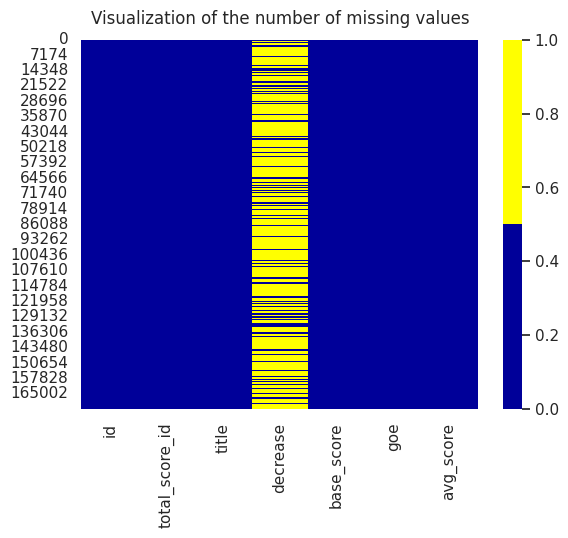


Процент пропущенных значений в признаках:
decrease: 76.08%
Количество уникальных значений в столбце 'id': 172158
Соотношение уникальных значений и общего количества записей в столбце 'id': 1.0000
Количество уникальных значений в столбце 'total_score_id': 21301
Соотношение уникальных значений и общего количества записей в столбце 'total_score_id': 0.1237


In [16]:
tournament_scores = tournament_scores_explorer.explore_dataset()

Выводы и наблюдения:
- дубликатов строк в данных не обнаружено;
- в признаке `decrease` пропущено более трёх четвертей значений,
  <br>возможно, он в последствии буде исключён;
- большинство признаков представлено числовыми значениями.

### merge_data

In [32]:
main_df = (
    tournament_scores
    .merge(scores, how='left', left_on='total_score_id', right_on='id', suffixes=('_ts', '_scores'))
    .merge(units, how='left', left_on='unit_id', right_on='id', suffixes=('_tss', '_units'))
    .merge(tournaments, how='left', left_on='tournament_id', right_on='id', suffixes=('_tssu', '_tournaments'))
)

## checkpoint_1

In [33]:
# merge_df.to_csv('data/merge_df.csv', index=False)
main_df = pd.read_csv('data/merge_df.csv', low_memory=False)

In [34]:
all_data_explorer = DatasetExplorer(data_path=None, data=main_df)

Общая информация по набору данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172158 entries, 0 to 172157
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id_ts                172158 non-null  int64  
 1   total_score_id       172158 non-null  int64  
 2   title                172158 non-null  object 
 3   decrease             41185 non-null   object 
 4   base_score_ts        172158 non-null  float64
 5   goe                  172158 non-null  float64
 6   avg_score            172158 non-null  float64
 7   id_scores            172158 non-null  int64  
 8   unit_id              172158 non-null  int64  
 9   tournament_id        172158 non-null  int64  
 10  base_score_scores    172158 non-null  float64
 11  components_score     172158 non-null  float64
 12  total_score          172158 non-null  float64
 13  elements_score       172158 non-null  float64
 14  decreasings_score    172158 non-n

,id_ts,total_score_id,title,decrease,base_score_ts,goe,avg_score,id_scores,unit_id,tournament_id,base_score_scores,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str,id_tssu,color,school_id,id_tournaments,date_start,date_end,origin_id
0,1,1,2A,NaN,3.3,0.66,3.96,1,1,1,31.99,24.67,56.86,33.19,0.0,2,5,Короткая программа,x Надбавка за прыжки во второй половине програ...,4,164.44,NaN,1,green,198.0,1,2090-11-29,2090-12-01,2.0
1,2,1,3F+3Lo,NaN,10.2,-0.11,10.09,1,1,1,31.99,24.67,56.86,33.19,0.0,2,5,Короткая программа,x Надбавка за прыжки во второй половине програ...,4,164.44,NaN,1,green,198.0,1,2090-11-29,2090-12-01,2.0
2,3,1,3Lz,NaN,0.0,-1.30,5.19,1,1,1,31.99,24.67,56.86,33.19,0.0,2,5,Короткая программа,x Надбавка за прыжки во второй половине програ...,4,164.44,NaN,1,green,198.0,1,2090-11-29,2090-12-01,2.0
3,4,1,CCoSp4,NaN,3.5,0.56,4.06,1,1,1,31.99,24.67,56.86,33.19,0.0,2,5,Короткая программа,x Надбавка за прыжки во второй половине програ...,4,164.44,NaN,1,green,198.0,1,2090-11-29,2090-12-01,2.0
4,5,1,FCSp4,NaN,3.2,0.64,3.84,1,1,1,31.99,24.67,56.86,33.19,0.0,2,5,Короткая программа,x Надбавка за прыжки во второй половине програ...,4,164.44,NaN,1,green,198.0,1,2090-11-29,2090-12-01,2.0



Количество полных дубликатов строк:


0


Количество пропущенных значений:


id_ts                  0
total_score_id         0
title                  0
decrease          130973
base_score_ts          0
                   ...  
school_id           7245
id_tournaments         0
date_start             0
date_end               0
origin_id              0
Length: 29, dtype: int64

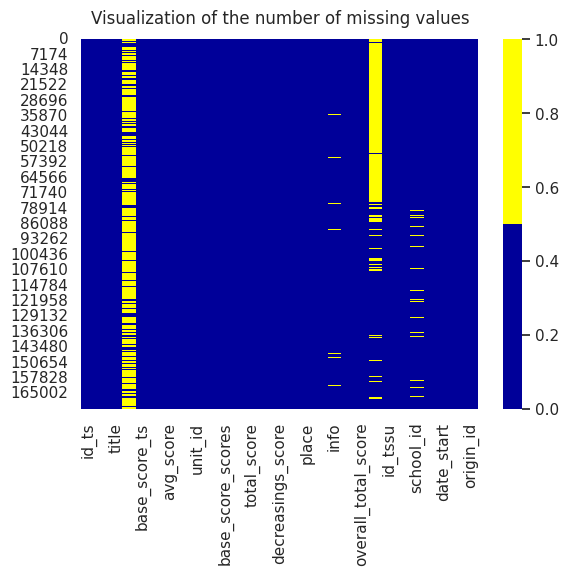


Процент пропущенных значений в признаках:
decrease: 76.08%
segment_name: 0.02%
info: 2.21%
overall_total_score: 0.02%
overall_place_str: 50.08%
school_id: 4.21%
Количество уникальных значений в столбце 'id_ts': 172158
Соотношение уникальных значений и общего количества записей в столбце 'id_ts': 1.0000
Количество уникальных значений в столбце 'total_score_id': 21301
Соотношение уникальных значений и общего количества записей в столбце 'total_score_id': 0.1237
Количество уникальных значений в столбце 'id_scores': 21301
Соотношение уникальных значений и общего количества записей в столбце 'id_scores': 0.1237
Количество уникальных значений в столбце 'unit_id': 3393
Соотношение уникальных значений и общего количества записей в столбце 'unit_id': 0.0197
Количество уникальных значений в столбце 'tournament_id': 142
Соотношение уникальных значений и общего количества записей в столбце 'tournament_id': 0.0008
Количество уникальных значений в столбце 'id_tssu': 3393
Соотношение уникальных знач

In [35]:
main_df = all_data_explorer.explore_dataset(target=None, assets_dir=None)

In [ ]:
features_for_analysis = ['base_score_ts',
                         'goe','avg_score',
                         'base_score_scores',
                         'components_score',
                         'total_score',
                         'elements_score',
                         'decreasing_score',
                         'starting_place',
                         'place',
                         'overall_place',
                         'overall_total_score',
                         'color',
                         'origin_id']

fig, axs = plt.subplots(7, 2)
fig.tight_layout(pad=1.0)
fig.set_size_inches(14, 20, forward=True)

for i, col in enumerate(features_for_analysis):
    agg_df = main_df.groupby(col).agg({'pr_sales_in_units': 'sum'}).reset_index()
    agg_df = agg_df.sort_values(by=col)
    # agg_df[col] = agg_df[col].astype(str)
    sns.barplot(x=col,
                y='pr_sales_in_units',
                data=agg_df,
                ax=axs[i // 2, i % 2],
                hue=col,
                palette=sns.color_palette("husl", len(agg_df)),
                legend=False)
    axs[i // 2, i % 2].set_title(f'Sum sales_in_units by {col} in data')
    axs[i // 2, i % 2].set_xticks(range(len(agg_df)))
    axs[i // 2, i % 2].set_xticklabels(agg_df[col], rotation=45, ha='right')
    axs[i // 2, i % 2].set_ylabel('sales_in_units')
fig.suptitle('Sum of sales_in_units by category')
# plt.savefig(os.path.join(ASSETS_DIR, 'Sum of sales_in_units by category.png'))
plt.show()

In [45]:
main_df.head()

,id_ts,total_score_id,title,decrease,base_score_ts,goe,avg_score,id_scores,unit_id,tournament_id,base_score_scores,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str,id_tssu,color,school_id,id_tournaments,date_start,date_end,origin_id
0,1,1,2A,NaN,3.3,0.66,3.96,1,1,1,31.99,24.67,56.86,33.19,0.0,2,5,Короткая программа,x Надбавка за прыжки во второй половине програ...,4,164.44,NaN,1,green,198.0,1,2090-11-29,2090-12-01,2.0
1,2,1,3F+3Lo,NaN,10.2,-0.11,10.09,1,1,1,31.99,24.67,56.86,33.19,0.0,2,5,Короткая программа,x Надбавка за прыжки во второй половине програ...,4,164.44,NaN,1,green,198.0,1,2090-11-29,2090-12-01,2.0
2,3,1,3Lz,NaN,0.0,-1.30,5.19,1,1,1,31.99,24.67,56.86,33.19,0.0,2,5,Короткая программа,x Надбавка за прыжки во второй половине програ...,4,164.44,NaN,1,green,198.0,1,2090-11-29,2090-12-01,2.0
3,4,1,CCoSp4,NaN,3.5,0.56,4.06,1,1,1,31.99,24.67,56.86,33.19,0.0,2,5,Короткая программа,x Надбавка за прыжки во второй половине програ...,4,164.44,NaN,1,green,198.0,1,2090-11-29,2090-12-01,2.0
4,5,1,FCSp4,NaN,3.2,0.64,3.84,1,1,1,31.99,24.67,56.86,33.19,0.0,2,5,Короткая программа,x Надбавка за прыжки во второй половине програ...,4,164.44,NaN,1,green,198.0,1,2090-11-29,2090-12-01,2.0


In [ ]:
features_to_delete = ['id_scores', 'id_tssu']

## Feature engineering

In [40]:
main_df['date_start'] = pd.to_datetime(main_df['date_start'], format='%Y-%m-%d')
main_df['date_end'] = pd.to_datetime(main_df['date_end'], format='%Y-%m-%d')

In [43]:
display(main_df['date_start'].min(), main_df['date_start'].max())
display(main_df['date_end'].min(), main_df['date_end'].max())

Timestamp('2089-09-20 00:00:00')

Timestamp('2092-04-29 00:00:00')

Timestamp('2089-09-23 00:00:00')

Timestamp('2092-05-03 00:00:00')